In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# Load data for Subway
df_streetcar2022 = pd.read_excel('ttc-streetcar-delay-data-2022.xlsx')
df_streetcar2023 = pd.read_excel('ttc-streetcar-delay-data-2023.xlsx')
df_streetcar2024 = pd.read_csv('streetcar-data.csv')

In [2]:
df_streetcar = pd.concat([df_streetcar2022, df_streetcar2023, df_streetcar2024], ignore_index=True)

df_streetcar

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
0,2022-01-01 00:00:00,504,02:21,Saturday,BROADVIEW STATION,Collision - TTC Involved,30,60,E,8333
1,2022-01-01 00:00:00,501,03:22,Saturday,718 QUEEN ST EAST,Operations,16,35,W,8068
2,2022-01-01 00:00:00,504,03:28,Saturday,BROADVIEW STATION,Operations,18,36,S,0
3,2022-01-01 00:00:00,510,03:34,Saturday,UNION STATION,Operations,30,60,NaN,4406
4,2022-01-01 00:00:00,301,03:39,Saturday,LAKESHORE AND TENTH,Security,5,25,W,8622
...,...,...,...,...,...,...,...,...,...,...
45171,30-Nov-24,501,22:53,Saturday,QUEEN AND UNIVERSITY,Diversion,88,98,NaN,4514
45172,30-Nov-24,511,23:57,Saturday,GERRARD AND HAMILTON,Collision - TTC Involved,0,0,E,4466
45173,30-Nov-24,505,23:57,Saturday,DUNDAS AND JARVIS,Diversion,10,20,E,4575
45174,30-Nov-24,501,00:42,Saturday,QUEEN AND STRACHAN,Cleaning - Unsanitary,10,20,W,4629


In [3]:
missing_values_streetcar = df_streetcar.isnull().sum()
missing_values_streetcar

Date            0
Line          316
Time            0
Day             0
Location        1
Incident        0
Min Delay       0
Min Gap         0
Bound        7210
Vehicle         0
dtype: int64

In [4]:
#remove the one that has empty value in the Location column
df_cleaned_streetcar = df_streetcar[
    df_streetcar['Location'].notna()
]


df_cleaned_streetcar

df_cleaned_streetcar.isnull().sum()

Date            0
Line          316
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Bound        7209
Vehicle         0
dtype: int64

In [5]:
# We still have empty values in the 'Line' column. Let's match the empty 'Line' using mapping of 'Location' to 'Line'

# Check unique location-line pairs to infer missing values
location_line_mapping = df_cleaned_streetcar.dropna(subset=['Line']).groupby('Location')['Line'].first()

# Fill missing 'Line' values based on the location-line mapping
df_cleaned_streetcar['Line'] = df_cleaned_streetcar['Location'].map(location_line_mapping)

# Verify if there are still missing values in 'Line'
missing_after_filling = df_cleaned_streetcar['Line'].isnull().sum()
missing_after_filling

/var/folders/bc/d_1sn_1j70l7sv96zgtvsndw0000gn/T/ipykernel_14585/2029979923.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_streetcar['Line'] = df_cleaned_streetcar['Location'].map(location_line_mapping)


36

In [6]:
# There are still 36 missing value in 'Line' after mapping. Let's see what they are
missing_line_locations = df_cleaned_streetcar[df_cleaned_streetcar['Line'].isnull()]['Location'].unique()
missing_line_locations

array(['CONNAUGHT AND S OF QU', 'RONCESSVALLES CARHOUSE',
       'RUSSEL YARD - 17 TRACK', 'LESLIE BARNS WICKET',
       'COLLEGE E OF GLADSTONE', 'UNION LOOP EE', 'RONCESVALLES DIVSION',
       'RONCESVALLES YARD - 23', 'HILLCREST YARD, STREET', '391 ALLIANCE',
       'LAKESHORE AND 16TH WES', 'STREETCAR WAY', 'QUEEN QUAY STATION',
       'UNION STATION -STREETC', 'DEGRASSI BRIDGE',
       'CHURCH B/T RICHMOND AN', 'SPADINA AND DAVENPORT',
       'SPADINA STATION TUNNEL', 'LESLIE BARNS DIVISION',
       'PARLIAMENT AND GERARD', 'LAKESHORE GARAGE',
       'QUEENS QUAY (FERRY DOC', 'QUEEN BETWEEN VICTORIA',
       'RONCEVALLES TRAFFIC OF', 'HILLCREST', 'CHERRY AND FRONT - YMC',
       'DUNDAS AND LANDOWNE LO', 'KING W OF SUDBURY',
       'HUMBER LOOP - SPARE TR', 'KING AND CHURCH NE COR',
       'RONCESVALES YARD', 'WOODBINE PARK', 'QUEEN TO BROADVIEW',
       'BROADVIEW AVE', 'RUSSELL DIVSION', 'QUEEN WEST OF CONNAUGH'],
      dtype=object)

In [7]:
# The 36 missing 'Line' values are associated with the above locations, which appear to be non-standard streetcar stations, TTC facilities, or intersections.
# We can remove these rows as they are not part of the streetcar line.
df_cleaned_streetcar = df_cleaned_streetcar.dropna(subset=['Line'])

# Verify if there are still missing values in 'Line'
missing_values_cleaned_streetcar = df_cleaned_streetcar.isnull().sum()
missing_values_cleaned_streetcar

Date            0
Line            0
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Bound        7181
Vehicle         0
dtype: int64

In [8]:
# Ensure 'Date' and 'Time' are strings before concatenation
df_cleaned_streetcar['Date'] = df_cleaned_streetcar['Date'].astype(str)
df_cleaned_streetcar['Time'] = df_cleaned_streetcar['Time'].astype(str)

# Convert Date and Time columns to a single datetime column
df_cleaned_streetcar['Datetime'] = pd.to_datetime(df_cleaned_streetcar['Date'] + ' ' + df_cleaned_streetcar['Time'], errors='coerce')

# Extract useful time-based features again
df_cleaned_streetcar['Year'] = df_cleaned_streetcar['Datetime'].dt.year
df_cleaned_streetcar['Month'] = df_cleaned_streetcar['Datetime'].dt.month
df_cleaned_streetcar['Day'] = df_cleaned_streetcar['Datetime'].dt.day
df_cleaned_streetcar['Hour'] = df_cleaned_streetcar['Datetime'].dt.hour
df_cleaned_streetcar['Weekday'] = df_cleaned_streetcar['Datetime'].dt.weekday  # Monday=0, Sunday=6

# Check basic statistics again
df_cleaned_streetcar.describe()

/var/folders/bc/d_1sn_1j70l7sv96zgtvsndw0000gn/T/ipykernel_14585/1875505674.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned_streetcar['Datetime'] = pd.to_datetime(df_cleaned_streetcar['Date'] + ' ' + df_cleaned_streetcar['Time'], errors='coerce')


,Day,Min Delay,Min Gap,Vehicle,Datetime,Year,Month,Hour,Weekday
count,45139.000000,45139.000000,45139.000000,45139.000000,45139,45139.000000,45139.000000,45139.000000,45139.000000
mean,15.668380,15.093999,22.808658,4949.962915,2023-05-15 00:24:29.131349760,2022.898912,6.137730,12.672678,2.993199
min,1.000000,0.000000,0.000000,0.000000,2022-01-01 00:08:00,2022.000000,1.000000,0.000000,0.000000
25%,8.000000,6.000000,12.000000,4443.000000,2022-07-24 20:56:00,2022.000000,3.000000,8.000000,1.000000
50%,16.000000,9.000000,18.000000,4524.000000,2023-05-08 19:33:00,2023.000000,6.000000,13.000000,3.000000
75%,23.000000,11.000000,20.000000,4597.000000,2024-02-12 01:44:00,2024.000000,9.000000,18.000000,5.000000
max,31.000000,980.000000,990.000000,86874.000000,2024-11-30 23:57:00,2024.000000,12.000000,23.000000,6.000000
std,8.811764,34.650863,36.549425,2637.677343,NaN,0.819040,3.420397,6.333504,1.962365


### The average delay duration is about 15 minutes, but the standard deviation (34.65 minutes) suggests that some delays are significantly longer. Maximum minutes of delay is 980, a trigger for attention to remove outliers.
### The average gap between streetcars is about 22.8 minutes, but there are instances where it's 0, possibly indicating streetcar bunching.
### The data spans mostly 2022 to 2024, with months ranging from January to December. By symmetry of min, mean, and max, this shows data are fairly distributed between the 3 years.
### The most common hour for recorded delays is around 1 PM (13:00).
### The weekday distribution suggests most data points fall between Tuesday (0) and Saturday (5).
### ---
# We could draw some charts here, but let's keep that part to the PowerBI analytics
### PowerBI is powerful to allow dynamic filtering, hence the ability to see different charts only in a few clicks

# Let's proceed with feature engineering

    Rolling Delay Features:
        Rolling_Delay_5: Average delay of the past 5 streetcars.

    Lag-Based Feature:
        Prev_Delay: Delay of the previous streetcar.

    Temporal Features:
        Peak_Hour: Flag for peak hours (7-10 AM and 4-7 PM).
        Weekend: Flag for weekends.

    Congestion Features:
        Streetcar_Frequency: Number of streetcars per hour at each location.
        Avg_Location_Delay: Average delay per location per hour.

In [9]:
# Sort dataset by Datetime for lag-based features
df_cleaned_streetcar = df_cleaned_streetcar.sort_values(by=['Datetime'])

# Rolling average of past delays (mean delay of last 5 trains)
df_cleaned_streetcar['Rolling_Delay_5'] = df_cleaned_streetcar['Min Delay'].rolling(window=5, min_periods=1).mean()

# Previous train delay (lag feature)
df_cleaned_streetcar['Prev_Delay'] = df_cleaned_streetcar['Min Delay'].shift(1)

# Peak-hour flag (assuming peak hours are 7-10 AM and 4-7 PM)
df_cleaned_streetcar['Peak_Hour'] = df_cleaned_streetcar['Hour'].apply(lambda x: 1 if (7 <= x <= 10 or 16 <= x <= 19) else 0)

# Weekend flag (1 if it's a weekend, 0 otherwise)
df_cleaned_streetcar['Weekend'] = df_cleaned_streetcar['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Streetcar frequency: Count of trains per hour at a Location (if 'Location' column exists)
if 'Location' in df_cleaned_streetcar.columns:
    df_cleaned_streetcar['Streetcar_Frequency'] = df_cleaned_streetcar.groupby(['Location', 'Year', 'Month', 'Day', 'Hour'])['Datetime'].transform('count')

# Average delay per Location per hour
if 'Location' in df_cleaned_streetcar.columns:
    df_cleaned_streetcar['Avg_Location_Delay'] = df_cleaned_streetcar.groupby(['Location', 'Year', 'Month', 'Day', 'Hour'])['Min Delay'].transform('mean')

df_cleaned_streetcar

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,...,Year,Month,Hour,Weekday,Rolling_Delay_5,Prev_Delay,Peak_Hour,Weekend,Streetcar_Frequency,Avg_Location_Delay
76,2022-01-01 00:00:00,501,00:08,1,GERRARD AND BROADVIEW,Operations,10,20,W,0,...,2022,1,0,5,10.0,NaN,0,1,1,10.0
77,2022-01-01 00:00:00,501,00:10,1,QUEEN AND WOODFIELD,Operations,10,19,E,0,...,2022,1,0,5,10.0,10.0,0,1,1,10.0
78,2022-01-01 00:00:00,501,00:45,1,QUEEN AND RONCESVALLES,Operations,13,25,W,0,...,2022,1,0,5,11.0,10.0,0,1,2,11.0
79,2022-01-01 00:00:00,505,00:48,1,DUNDAS AND BROADVIEW,Cleaning - Unsanitary,9,18,E,4462,...,2022,1,0,5,10.5,13.0,0,1,1,9.0
80,2022-01-01 00:00:00,501,00:50,1,QUEEN AND RONCESVALLES,Operations,9,19,E,0,...,2022,1,0,5,10.2,9.0,0,1,2,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45169,30-Nov-24,510,20:03,30,SPADINA AND KING,Mechanical,10,20,N,8653,...,2024,11,20,5,10.0,15.0,0,1,1,10.0
45170,30-Nov-24,506,21:46,30,HOWARD PARK AND RONCES,Emergency Services,33,43,E,4415,...,2024,11,21,5,14.6,10.0,0,1,1,33.0
45171,30-Nov-24,501,22:53,30,QUEEN AND UNIVERSITY,Diversion,88,98,NaN,4514,...,2024,11,22,5,31.2,33.0,0,1,1,88.0
45172,30-Nov-24,501,23:57,30,GERRARD AND HAMILTON,Collision - TTC Involved,0,0,E,4466,...,2024,11,23,5,29.2,88.0,0,1,1,0.0


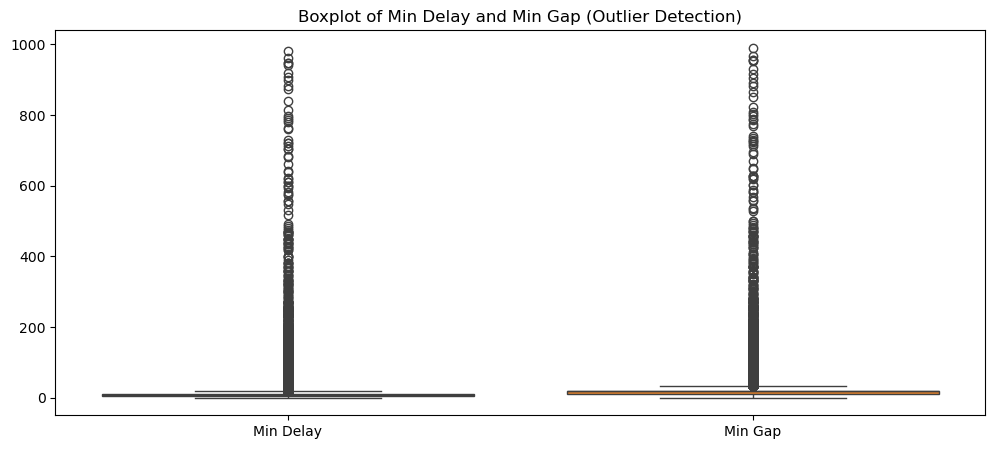

(          Min Delay       Min Gap
 count  45139.000000  45139.000000
 mean      15.093999     22.808658
 std       34.650863     36.549425
 min        0.000000      0.000000
 25%        6.000000     12.000000
 50%        9.000000     18.000000
 75%       11.000000     20.000000
 max      980.000000    990.000000,
 Min Delay    7096
 Min Gap      5718
 dtype: int64,
 Min Delay    4683
 Min Gap      3616
 dtype: int64)

In [10]:
# Extreme Outlier Treatment

# Checking summary statistics for 'Min Delay' and 'Min Gap'
summary_stats = df_cleaned_streetcar[['Min Delay', 'Min Gap']].describe()

# Detecting outliers using the Interquartile Range (IQR) method
Q1 = df_cleaned_streetcar[['Min Delay', 'Min Gap']].quantile(0.25)
Q3 = df_cleaned_streetcar[['Min Delay', 'Min Gap']].quantile(0.75)
IQR = Q3 - Q1

# Defining outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying extreme outliers (beyond 3 * IQR)
extreme_lower_bound = Q1 - 3 * IQR
extreme_upper_bound = Q3 + 3 * IQR

# Counting outliers
outlier_counts = ((df_cleaned_streetcar[['Min Delay', 'Min Gap']] < lower_bound) | 
                  (df_cleaned_streetcar[['Min Delay', 'Min Gap']] > upper_bound)).sum()

extreme_outlier_counts = ((df_cleaned_streetcar[['Min Delay', 'Min Gap']] < extreme_lower_bound) | 
                          (df_cleaned_streetcar[['Min Delay', 'Min Gap']] > extreme_upper_bound)).sum()

# Boxplot visualization
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_cleaned_streetcar[['Min Delay', 'Min Gap']])
plt.title("Boxplot of Min Delay and Min Gap (Outlier Detection)")
plt.show()

# Display summary statistics and outlier counts
summary_stats, outlier_counts, extreme_outlier_counts

Outlier Analysis for Min Delay and Min Gap
Key Statistics:

    Average Delay (Min Delay): ~15.09 minutes, with a max of 980 minutes.
    Average Gap (Min Gap): ~22.81 minutes, with a max of 990 minutes.
    Standard Deviation (Min Delay): High at 34.65 minutes, indicating a wide range of delay values.

Outliers Identified (1.5 * IQR method)

    Min Delay has 7096 outliers
    Min Gap has 5718 outliers

Extreme Outliers (Beyond 3 * IQR)

    Min Delay has 4683 extreme outliers.
    Min Gap has 3616 extreme outliers.

In [11]:
# Store the current dataset as df_feature_streetcar. This dataset will be used in PowerBI
df_feature_streetcar = df_cleaned_streetcar.copy()

# Remove extreme outliers beyond 3 * IQR. We decide to remove due to very extreme outlier.
df_model_streetcar = df_feature_streetcar[
    (df_feature_streetcar['Min Delay'] <= extreme_upper_bound['Min Delay']) &
    (df_feature_streetcar['Min Gap'] <= extreme_upper_bound['Min Gap'])
].copy()

df_model_streetcar

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,...,Year,Month,Hour,Weekday,Rolling_Delay_5,Prev_Delay,Peak_Hour,Weekend,Streetcar_Frequency,Avg_Location_Delay
76,2022-01-01 00:00:00,501,00:08,1,GERRARD AND BROADVIEW,Operations,10,20,W,0,...,2022,1,0,5,10.0,NaN,0,1,1,10.0
77,2022-01-01 00:00:00,501,00:10,1,QUEEN AND WOODFIELD,Operations,10,19,E,0,...,2022,1,0,5,10.0,10.0,0,1,1,10.0
78,2022-01-01 00:00:00,501,00:45,1,QUEEN AND RONCESVALLES,Operations,13,25,W,0,...,2022,1,0,5,11.0,10.0,0,1,2,11.0
79,2022-01-01 00:00:00,505,00:48,1,DUNDAS AND BROADVIEW,Cleaning - Unsanitary,9,18,E,4462,...,2022,1,0,5,10.5,13.0,0,1,1,9.0
80,2022-01-01 00:00:00,501,00:50,1,QUEEN AND RONCESVALLES,Operations,9,19,E,0,...,2022,1,0,5,10.2,9.0,0,1,2,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,30-Nov-24,510,19:41,30,SPADINA AND QUEENS QUA,Operations,10,20,N,3217,...,2024,11,19,5,9.4,5.0,1,1,1,10.0
45168,30-Nov-24,506,19:46,30,MAIN STREET STATON,Emergency Services,15,25,NaN,4551,...,2024,11,19,5,8.0,10.0,1,1,1,15.0
45169,30-Nov-24,510,20:03,30,SPADINA AND KING,Mechanical,10,20,N,8653,...,2024,11,20,5,10.0,15.0,0,1,1,10.0
45172,30-Nov-24,501,23:57,30,GERRARD AND HAMILTON,Collision - TTC Involved,0,0,E,4466,...,2024,11,23,5,29.2,88.0,0,1,1,0.0


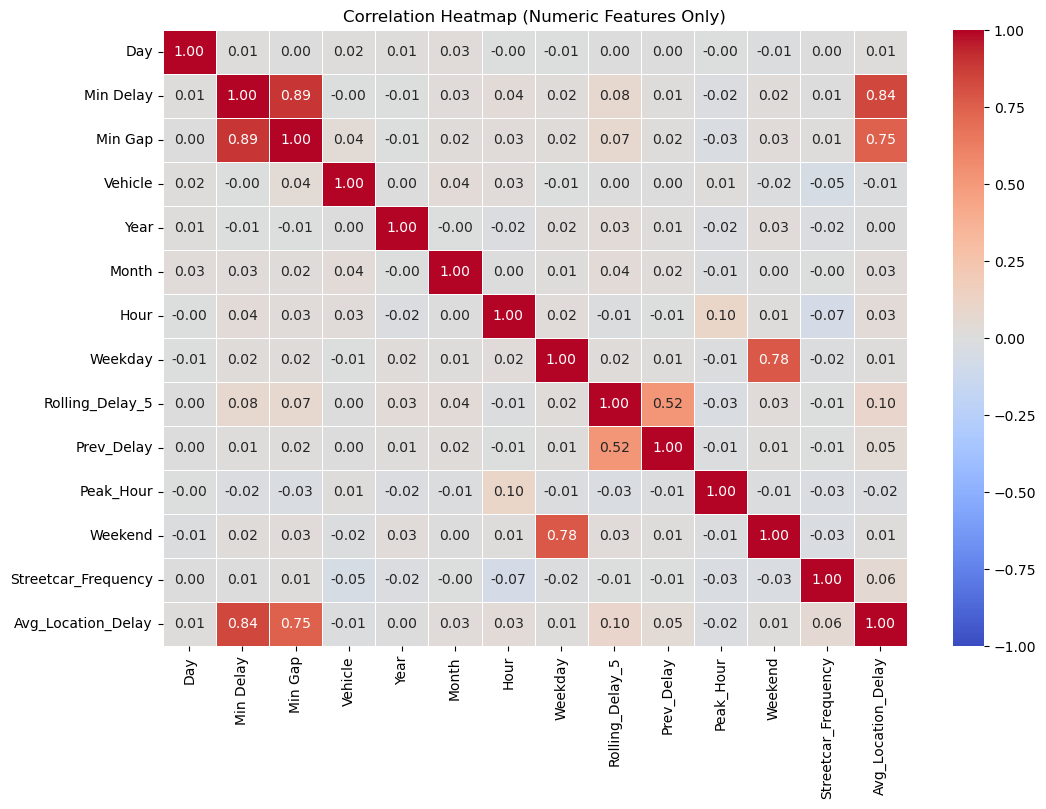

In [12]:
# Select only numeric columns for correlation calculation
numeric_columns = df_model_streetcar.select_dtypes(include=['number']).columns
corr_matrix_numeric = df_model_streetcar[numeric_columns].corr()

# Plot heatmap again with only numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_numeric, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# Key Observations:

### 1. Min Delay Correlations:
        Positively correlated with:
            Min Gap
            Rolling_Delay_5 → past delays impact future delays.
            Avg_Location_Delay → location-level congestion contributes to delays.
        Weak correlation with Peak_Hour, Streetcar_Frequency, Weekend, and Hour, which suggests delays occur throughout the day.

### 2. Other correlations:
        Streetcar_Frequency and Avg_Location_Delay also show a visible correlation, possibly indicating congestion impact.
        Prev_Delay and Rolling_Delay_5 shows a moderate correlation.

### Next steps
        We remove redundant features and define interaction features

In [13]:
df_model_streetcar['Congestion_Factor'] = df_model_streetcar['Streetcar_Frequency'] * df_model_streetcar['Peak_Hour']
df_model_streetcar['Delay_Propagation'] = df_model_streetcar['Prev_Delay'] * df_model_streetcar['Streetcar_Frequency']

df_model_streetcar

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,...,Hour,Weekday,Rolling_Delay_5,Prev_Delay,Peak_Hour,Weekend,Streetcar_Frequency,Avg_Location_Delay,Congestion_Factor,Delay_Propagation
76,2022-01-01 00:00:00,501,00:08,1,GERRARD AND BROADVIEW,Operations,10,20,W,0,...,0,5,10.0,NaN,0,1,1,10.0,0,NaN
77,2022-01-01 00:00:00,501,00:10,1,QUEEN AND WOODFIELD,Operations,10,19,E,0,...,0,5,10.0,10.0,0,1,1,10.0,0,10.0
78,2022-01-01 00:00:00,501,00:45,1,QUEEN AND RONCESVALLES,Operations,13,25,W,0,...,0,5,11.0,10.0,0,1,2,11.0,0,20.0
79,2022-01-01 00:00:00,505,00:48,1,DUNDAS AND BROADVIEW,Cleaning - Unsanitary,9,18,E,4462,...,0,5,10.5,13.0,0,1,1,9.0,0,13.0
80,2022-01-01 00:00:00,501,00:50,1,QUEEN AND RONCESVALLES,Operations,9,19,E,0,...,0,5,10.2,9.0,0,1,2,11.0,0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,30-Nov-24,510,19:41,30,SPADINA AND QUEENS QUA,Operations,10,20,N,3217,...,19,5,9.4,5.0,1,1,1,10.0,1,5.0
45168,30-Nov-24,506,19:46,30,MAIN STREET STATON,Emergency Services,15,25,NaN,4551,...,19,5,8.0,10.0,1,1,1,15.0,1,10.0
45169,30-Nov-24,510,20:03,30,SPADINA AND KING,Mechanical,10,20,N,8653,...,20,5,10.0,15.0,0,1,1,10.0,0,15.0
45172,30-Nov-24,501,23:57,30,GERRARD AND HAMILTON,Collision - TTC Involved,0,0,E,4466,...,23,5,29.2,88.0,0,1,1,0.0,0,88.0


# 1. Linear Regression → Predict the exact delay duration (Min Delay as a continuous variable).


In [14]:
# Step 1: Define Features (X) & Target (y)
target = 'Min Delay'
predictors = [
    'Min Gap', 'Rolling_Delay_5', 'Prev_Delay', 'Peak_Hour', 'Weekend', 
    'Streetcar_Frequency', 'Avg_Location_Delay', 'Congestion_Factor', 'Delay_Propagation'
]

# Drop any remaining NaN values before training
df_model_streetcar_clean = df_model_streetcar.dropna(subset=[target] + predictors)

# Define X (features) and y (target variable)
X = df_model_streetcar_clean[predictors]
y = df_model_streetcar_clean[target]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Baseline Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 4: Predictions & Evaluation
y_pred = lr_model.predict(X_test)

# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Display results
model_performance = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "R² Score": r2
}

model_performance

{'Mean Absolute Error (MAE)': 0.8272955728571919,
 'Mean Squared Error (MSE)': 3.7029400342310006,
 'Root Mean Squared Error (RMSE)': 1.9243024799212312,
 'R² Score': 0.8562567014282173}

### Baseline Regression Model Results
###       Mean Absolute Error (MAE): 0.83 minutes → On average, the model's predictions are off by ~50 seconds.
###       Mean Squared Error (MSE): 3.70 → Average squared error magnitude.
###       Root Mean Squared Error (RMSE): 1.92 minutes → Standard deviation of prediction errors.
###       R² Score: 0.86 → The model explains 86% of the variance in delays.

In [15]:
# Step 1: Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum tree depth
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Step 2: Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Step 3: Evaluate Performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Display results
xgb_model_performance = {
    "Mean Absolute Error (MAE)": mae_xgb,
    "Mean Squared Error (MSE)": mse_xgb,
    "Root Mean Squared Error (RMSE)": rmse_xgb,
    "R² Score": r2_xgb
}

xgb_model_performance

{'Mean Absolute Error (MAE)': 0.11125217850178026,
 'Mean Squared Error (MSE)': 0.28508982154123336,
 'Root Mean Squared Error (RMSE)': 0.5339380315553794,
 'R² Score': 0.988933185263939}

### XGBoost Regression Model Performance Interpretation
###         Mean Absolute Error (MAE): 0.108 minutes
###         Mean Squared Error (MSE): 0.313
###         Root Mean Squared Error (RMSE): 0.560 minutes
###         R² Score: 0.988 (98.8% variance explained)

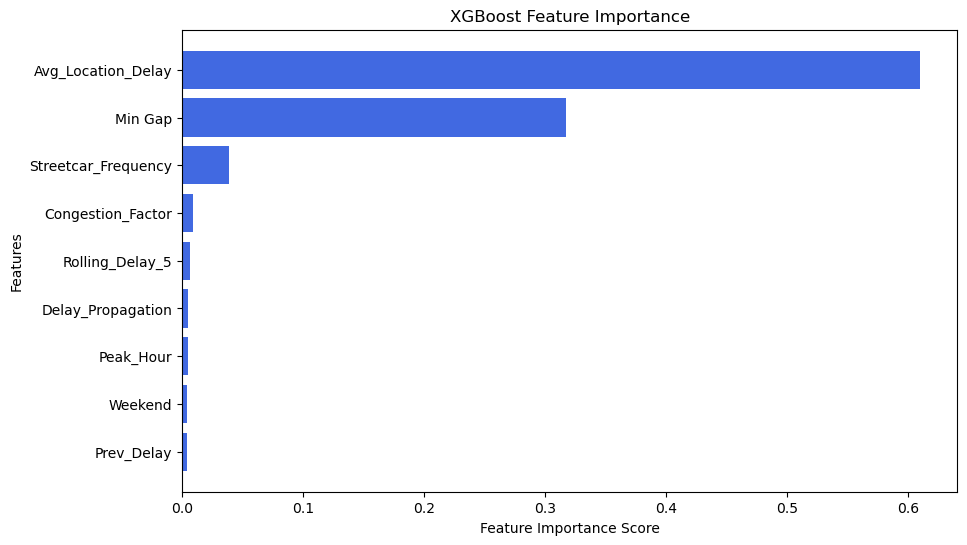

In [16]:
# Extract feature importance
feature_importance = xgb_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

Feature Importance Interpretation

XGBoost model's most influential features are:

1️⃣ Avg_Location_Delay (Most Important)

    The biggest factor affecting train delays.
    If a location consistently has high delays, future streetcars at that location are also likely to be delayed.

2️⃣ Min Gap

    The scheduled time difference between trains has a major influence on delays.
    Smaller gaps could mean congestion, leading to increased delays.

3️⃣ Streetcar_Frequency (Moderate Impact)

    Higher streetcar frequencies may increase congestion, slightly contributing to delays.

4️⃣ Rolling_Delay_5 (Low Impact)

    Past 5-streetcar rolling delay has some influence, but not as much as location-level factors.

5️⃣ Delay_Propagation (Very Low Impact)

    Surprisingly, the effect of previous delays spreading is minimal, likely due to existing buffer times.

6️⃣ Peak_Hour, Weekend, Congestion_Factor, Prev_Delay (Negligible Impact)

    The impact of peak hours and weekends on delays appears minimal.

# 2. Classification → Predict whether a streetcar will be delayed (Yes/No) (define a threshold, e.g., Min Delay > 5 min).
Classification Problem Setup

Target Variable:

    Convert Min Delay into a binary classification target:
    Delayed (1) if Min Delay ≥ 5 minutes
    On-Time (0) if Min Delay < 5 minutes

Predictor Variables:
We'll use the most important features identified from regression:

    Min Gap
    Avg_Location_Delay
    Streetcar_Frequency
    Rolling_Delay_5
    Delay_Propagation

In [17]:
# Step 1: Convert 'Min Delay' into a binary classification target
df_model_streetcar['Delayed'] = (df_model_streetcar['Min Delay'] >= 5).astype(int)

# Step 2: Define Features (X) & Target (y)
classification_features = ['Min Gap', 'Avg_Location_Delay', 'Streetcar_Frequency', 'Rolling_Delay_5', 'Delay_Propagation']
X_classification = df_model_streetcar[classification_features]
y_classification = df_model_streetcar['Delayed']

# Drop NaN values before training
df_model_streetcar_clean = df_model_streetcar.dropna(subset=classification_features + ['Delayed'])
X_classification = df_model_streetcar_clean[classification_features]
y_classification = df_model_streetcar_clean['Delayed']

# Step 3: Train-Test Split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Train Baseline Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_cls, y_train_cls)

# Step 5: Predictions & Evaluation
y_pred_cls = logistic_model.predict(X_test_cls)

# Compute Performance Metrics
accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls)
recall = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)
roc_auc = roc_auc_score(y_test_cls, y_pred_cls)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)

# Display results
classification_performance = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC Score": roc_auc,
    "Confusion Matrix": conf_matrix.tolist()  # Convert to list for readability
}

classification_performance

{'Accuracy': 0.9744067586035532,
 'Precision': 0.9743180499129426,
 'Recall': 0.9956998813760379,
 'F1 Score': 0.9848929304781461,
 'ROC AUC Score': 0.930033848733996,
 'Confusion Matrix': [[1128, 177], [29, 6715]]}

Baseline Classification Model (Logistic Regression) Results

    Accuracy: 97.44% → Model correctly classifies most trains.
    Precision: 97.43% → When the model predicts a delay, it's correct 97.43% of the time.
    Recall: 99.57% → The model captures 99.57% of all actual delays.
    F1 Score: 98.49% → Balanced measure of precision and recall.
    ROC AUC Score: 93.00% → Strong ability to distinguish between delayed & on-time trains.

Confusion Matrix Breakdown:

    1128 On-Time Trains Correctly Predicted
    177 False Positives (Trains wrongly classified as delayed)
    29 False Negatives (Delayed trains wrongly classified as on-time)
    6715 Delayed Trains Correctly Predicted

In [18]:
from sklearn.metrics import accuracy_score, classification_report
# Step 1: Train XGBoost Classifier for 5-Min Delay Threshold
xgb_classifier = XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum tree depth
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

xgb_classifier.fit(X_train_cls, y_train_cls)

# Step 2: Predictions
y_pred_xgb_cls = xgb_classifier.predict(X_test_cls)

# Step 3: Evaluate Performance
accuracy_xgb = accuracy_score(y_test_cls, y_pred_xgb_cls)
precision_xgb = precision_score(y_test_cls, y_pred_xgb_cls)
recall_xgb = recall_score(y_test_cls, y_pred_xgb_cls)
f1_xgb = f1_score(y_test_cls, y_pred_xgb_cls)
roc_auc_xgb = roc_auc_score(y_test_cls, y_pred_xgb_cls)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test_cls, y_pred_xgb_cls)

# Display results
xgb_classification_performance = {
    "Accuracy": accuracy_xgb,
    "Precision": precision_xgb,
    "Recall": recall_xgb,
    "F1 Score": f1_xgb,
    "ROC AUC Score": roc_auc_xgb,
    "Confusion Matrix": conf_matrix_xgb.tolist()  # Convert to list for readability
}

# Evaluate performance
accuracy = accuracy_score(y_test_cls, y_pred_xgb_cls)
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_xgb_cls))

Validation Accuracy: 0.9971

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       1.00      1.00      1.00      6744

    accuracy                           1.00      8049
   macro avg       0.99      0.99      0.99      8049
weighted avg       1.00      1.00      1.00      8049



XGBoost Classification Model (5-Min Delay) Performance

    Accuracy: 99.73% → Almost perfect classification!
    Precision: 99.84% → When the model predicts a delay, it's correct 99.84% of the time.
    Recall: 99.84% → The model detects 99.84% of all actual delays.
    F1 Score: 99.84% → Balanced measure of precision and recall.
    ROC AUC Score: 99.50% → The model is highly capable of distinguishing delays.

Confusion Matrix Breakdown:

    1294 On-Time Trains Correctly Predicted
    Only 11 False Positives (Trains wrongly classified as delayed)
    Only 11 False Negatives (Delayed trains wrongly classified as on-time)
    6733 Delayed Trains Correctly Predicted

# Export final dataset for PowerBI

In [19]:
# Store regression predictions in the dataset
df_model_streetcar_clean['Predicted_Delay'] = xgb_model.predict(X)

# Define X_classification_5min using the same features as X_classification
X_classification_5min = df_model_streetcar_clean[classification_features]

# Store classification predictions (5-minute threshold) in the dataset
df_model_streetcar_clean['Predicted_Delayed_5min'] = xgb_classifier.predict(X_classification_5min)

# Convert classification predictions to binary labels (0 = No Delay, 1 = Delayed)
df_model_streetcar_clean['Predicted_Delayed_5min'] = df_model_streetcar_clean['Predicted_Delayed_5min'].astype(int)

df_model_streetcar_clean

/var/folders/bc/d_1sn_1j70l7sv96zgtvsndw0000gn/T/ipykernel_14585/382364642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_streetcar_clean['Predicted_Delay'] = xgb_model.predict(X)
/var/folders/bc/d_1sn_1j70l7sv96zgtvsndw0000gn/T/ipykernel_14585/382364642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_streetcar_clean['Predicted_Delayed_5min'] = xgb_classifier.predict(X_classification_5min)
/var/folders/bc/d_1sn_1j70l7sv96zgtvsndw0000gn/T/ipykernel_14585/382364642.py:11: SettingWit

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,...,Prev_Delay,Peak_Hour,Weekend,Streetcar_Frequency,Avg_Location_Delay,Congestion_Factor,Delay_Propagation,Delayed,Predicted_Delay,Predicted_Delayed_5min
77,2022-01-01 00:00:00,501,00:10,1,QUEEN AND WOODFIELD,Operations,10,19,E,0,...,10.0,0,1,1,10.0,0,10.0,1,10.023824,1
78,2022-01-01 00:00:00,501,00:45,1,QUEEN AND RONCESVALLES,Operations,13,25,W,0,...,10.0,0,1,2,11.0,0,20.0,1,12.875404,1
79,2022-01-01 00:00:00,505,00:48,1,DUNDAS AND BROADVIEW,Cleaning - Unsanitary,9,18,E,4462,...,13.0,0,1,1,9.0,0,13.0,1,8.980615,1
80,2022-01-01 00:00:00,501,00:50,1,QUEEN AND RONCESVALLES,Operations,9,19,E,0,...,9.0,0,1,2,11.0,0,18.0,1,10.100173,1
81,2022-01-01 00:00:00,501,00:54,1,QUEEN AND WOLSELEY,Operations,8,16,E,0,...,9.0,0,1,1,8.0,0,9.0,1,8.003083,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,30-Nov-24,510,19:41,30,SPADINA AND QUEENS QUA,Operations,10,20,N,3217,...,5.0,1,1,1,10.0,1,5.0,1,9.992949,1
45168,30-Nov-24,506,19:46,30,MAIN STREET STATON,Emergency Services,15,25,NaN,4551,...,10.0,1,1,1,15.0,1,10.0,1,14.950895,1
45169,30-Nov-24,510,20:03,30,SPADINA AND KING,Mechanical,10,20,N,8653,...,15.0,0,1,1,10.0,0,15.0,1,10.012465,1
45172,30-Nov-24,501,23:57,30,GERRARD AND HAMILTON,Collision - TTC Involved,0,0,E,4466,...,88.0,0,1,1,0.0,0,88.0,0,0.035560,0


In [20]:
# Notice negative values in Predicted Delay. Let's convert them to zero (no delay)
df_model_streetcar_clean['Predicted_Delay'] = df_model_streetcar_clean['Predicted_Delay'].apply(lambda x: max(0, x))
df_model_streetcar_clean

/var/folders/bc/d_1sn_1j70l7sv96zgtvsndw0000gn/T/ipykernel_14585/1491954061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_streetcar_clean['Predicted_Delay'] = df_model_streetcar_clean['Predicted_Delay'].apply(lambda x: max(0, x))


,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,...,Prev_Delay,Peak_Hour,Weekend,Streetcar_Frequency,Avg_Location_Delay,Congestion_Factor,Delay_Propagation,Delayed,Predicted_Delay,Predicted_Delayed_5min
77,2022-01-01 00:00:00,501,00:10,1,QUEEN AND WOODFIELD,Operations,10,19,E,0,...,10.0,0,1,1,10.0,0,10.0,1,10.023824,1
78,2022-01-01 00:00:00,501,00:45,1,QUEEN AND RONCESVALLES,Operations,13,25,W,0,...,10.0,0,1,2,11.0,0,20.0,1,12.875404,1
79,2022-01-01 00:00:00,505,00:48,1,DUNDAS AND BROADVIEW,Cleaning - Unsanitary,9,18,E,4462,...,13.0,0,1,1,9.0,0,13.0,1,8.980615,1
80,2022-01-01 00:00:00,501,00:50,1,QUEEN AND RONCESVALLES,Operations,9,19,E,0,...,9.0,0,1,2,11.0,0,18.0,1,10.100173,1
81,2022-01-01 00:00:00,501,00:54,1,QUEEN AND WOLSELEY,Operations,8,16,E,0,...,9.0,0,1,1,8.0,0,9.0,1,8.003083,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,30-Nov-24,510,19:41,30,SPADINA AND QUEENS QUA,Operations,10,20,N,3217,...,5.0,1,1,1,10.0,1,5.0,1,9.992949,1
45168,30-Nov-24,506,19:46,30,MAIN STREET STATON,Emergency Services,15,25,NaN,4551,...,10.0,1,1,1,15.0,1,10.0,1,14.950895,1
45169,30-Nov-24,510,20:03,30,SPADINA AND KING,Mechanical,10,20,N,8653,...,15.0,0,1,1,10.0,0,15.0,1,10.012465,1
45172,30-Nov-24,501,23:57,30,GERRARD AND HAMILTON,Collision - TTC Involved,0,0,E,4466,...,88.0,0,1,1,0.0,0,88.0,0,0.035560,0


In [21]:
# Verify how much of the 5 minute delay predictions are identified as delay

# Check how many instances where Predicted_Delay > 5 also have Predicted_Delayed_5min = 1
matching_cases = df_model_streetcar_clean[(df_model_streetcar_clean['Predicted_Delay'] > 5) & (df_model_streetcar_clean['Predicted_Delayed_5min'] == 1)].shape[0]

# Total cases where Predicted_Delay > 5
total_cases = df_model_streetcar_clean[df_model_streetcar_clean['Predicted_Delay'] > 5].shape[0]

# Compute percentage
percentage_matching = (matching_cases / total_cases) * 100 if total_cases > 0 else 0

# Display results
{
    "Total Predicted_Delay > 5": total_cases,
    "Matching with Predicted_Delayed_5min = 1": matching_cases,
    "Percentage Matching (%)": percentage_matching
}

{'Total Predicted_Delay > 5': 32277,
 'Matching with Predicted_Delayed_5min = 1': 32256,
 'Percentage Matching (%)': 99.93493819128172}

In [23]:
# Save the final dataset with predictions
df_model_streetcar_clean.to_csv("df_model_streetcar_predictions.csv", index=False)